In [1]:
import healpy as hp
from pysm3 import units as u
import pysm3
import numpy as np
import matplotlib.pyplot as plt
import toml
from pathlib import Path

In [2]:
from astropy.table import QTable

In [3]:
cd ..

/mnt/home/azonca/p/software/litebirdXS4/20230810_foregrounds_cmb


In [4]:
config = toml.load("common.toml")

In [5]:
config["output_folder"] = "output/equatorial/{tag}"

In [6]:
# chs = chs[chs["telescope"]=="SAT"]

In [7]:
from astropy.io import fits

In [8]:
import mapsims

In [9]:
chs = mapsims.parse_channels(instrument_parameters=config["instrument_parameters"])

## Verify radio galaxies

In order to verify the Radio Galaxy maps, we take the brightest source (at the lowest frequencies) and check that the flux in Jy is similar to what is in the catalog.
I have separately gone through all the input maps and extracted the flux and saved it in a csv file.
Then I do a simple aperture photometry calculation to integrate the flux across the whole beam and compare it with the expected flux.

In [10]:
clon, clat, glon, glat = (32.86660645897463,
 -50.554023687565746,
 275.28891668590967,
 -62.06147137885603)

In [11]:
import pandas as pd

In [12]:
ref_flux = pd.read_csv("verification/reference_source_flux.csv", index_col=0)

Channel H3-402 radio_rg1 - Flux 4.66 Jy Ref flux 4.59 Jy Ratio 1.40%
Channel H2-337 radio_rg1 - Flux 5.99 Jy Ref flux 5.84 Jy Ratio 2.58%
Channel H1-280 radio_rg1 - Flux 7.80 Jy Ref flux 7.53 Jy Ratio 3.66%
Channel H2-235 radio_rg1 - Flux 9.98 Jy Ref flux 9.57 Jy Ratio 4.28%
Channel H1-195 radio_rg1 - Flux 12.99 Jy Ref flux 12.37 Jy Ratio 4.99%
Channel M1-195 radio_rg1 - Flux 12.98 Jy Ref flux 12.37 Jy Ratio 4.92%
Channel M2-166 radio_rg1 - Flux 16.21 Jy Ref flux 15.44 Jy Ratio 5.02%
Channel M1-140 radio_rg1 - Flux 21.12 Jy Ref flux 20.09 Jy Ratio 5.12%
Channel M2-119 radio_rg1 - Flux 28.15 Jy Ref flux 26.90 Jy Ratio 4.68%
Channel M1-100 radio_rg1 - Flux 38.45 Jy Ref flux 36.80 Jy Ratio 4.49%
Channel L4-140 radio_rg1 - Flux 21.04 Jy Ref flux 20.09 Jy Ratio 4.74%
Channel L3-119 radio_rg1 - Flux 28.06 Jy Ref flux 26.90 Jy Ratio 4.32%
Channel L4-100 radio_rg1 - Flux 38.32 Jy Ref flux 36.80 Jy Ratio 4.15%
Channel L2-089 radio_rg1 - Flux 49.08 Jy Ref flux 47.03 Jy Ratio 4.35%
Channel L3-089

/mnt/home/azonca/mambaforge-pypy3/envs/so/lib/python3.10/site-packages/healpy/visufunc.py:468: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(5.8, 6.4))


Flux 289.26 Jy Ref flux 279.55 Jy Ratio 3.47%


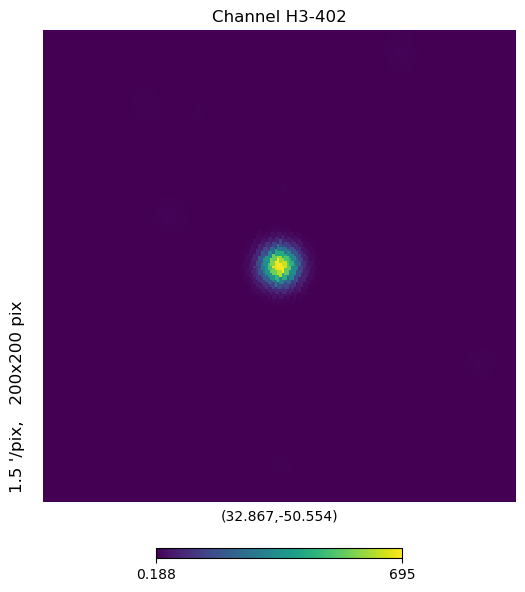

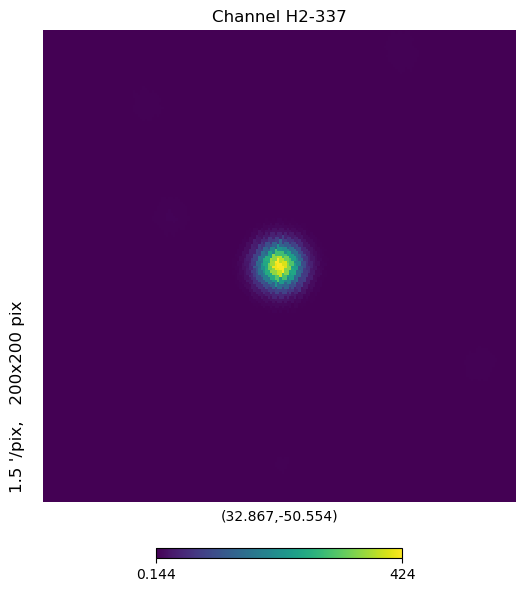

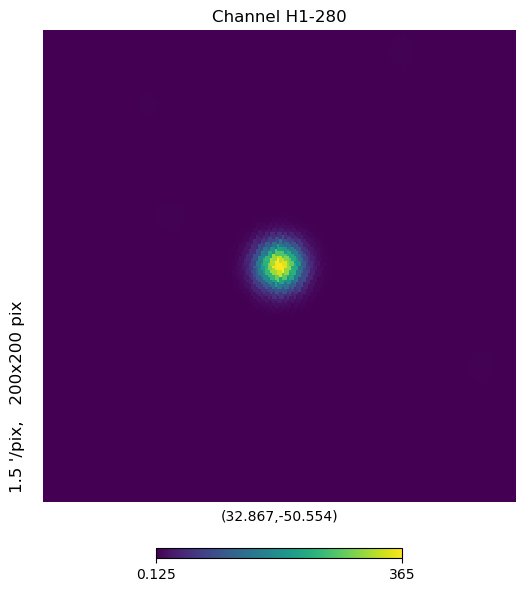

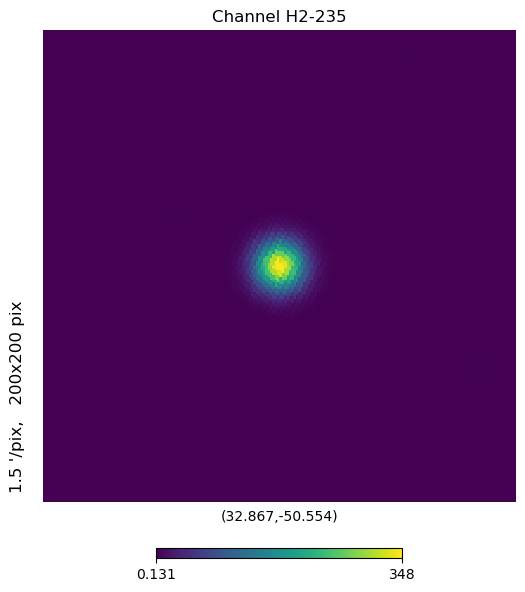

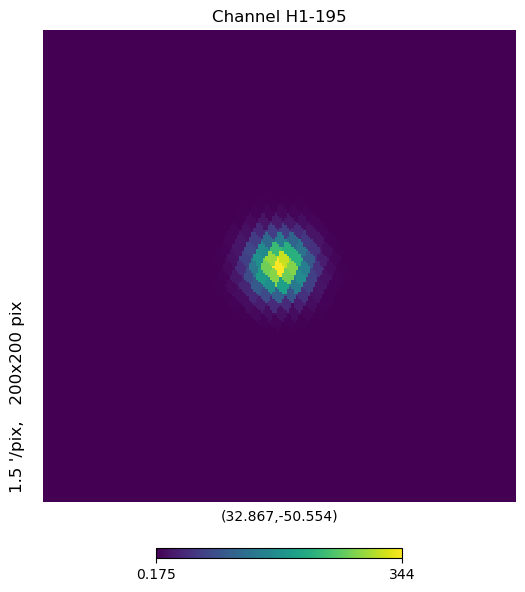

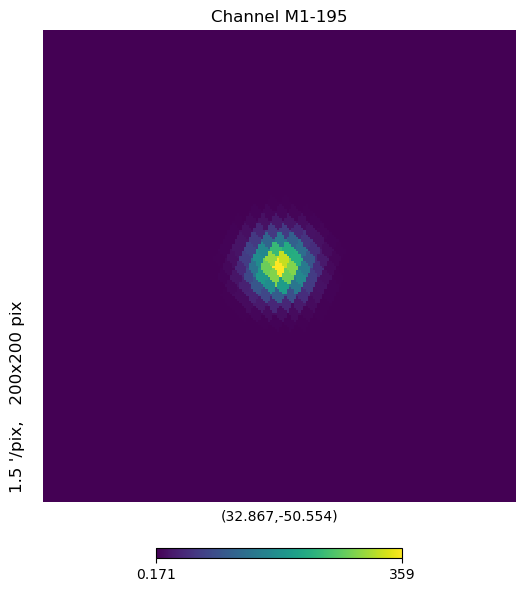

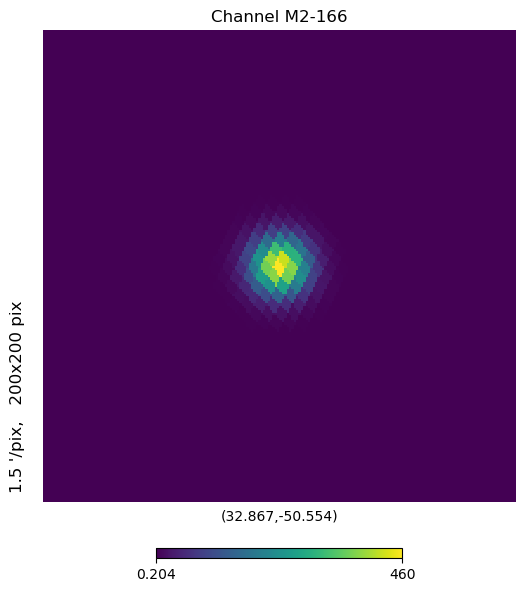

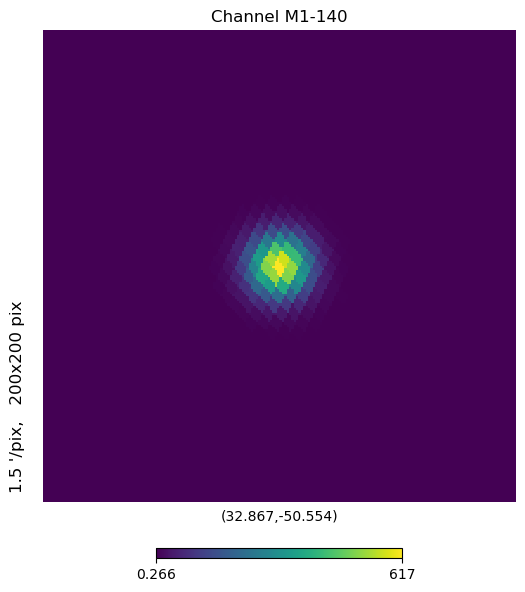

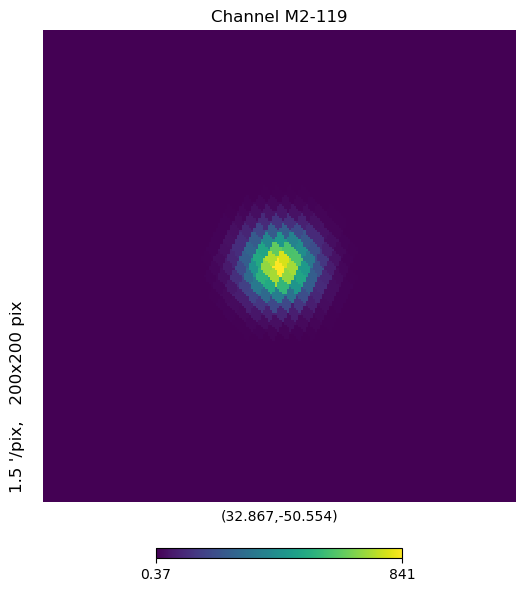

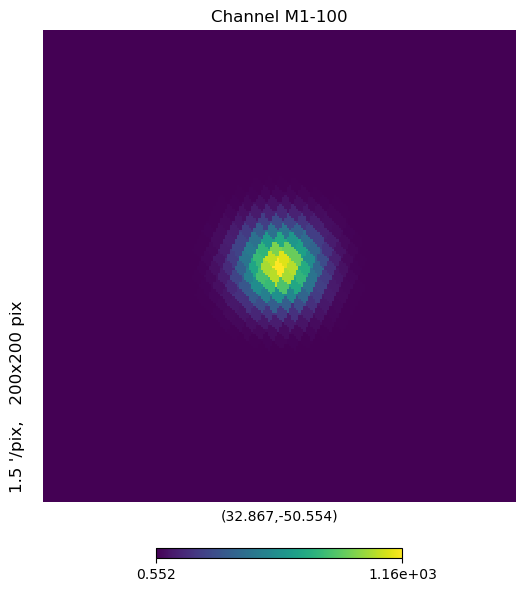

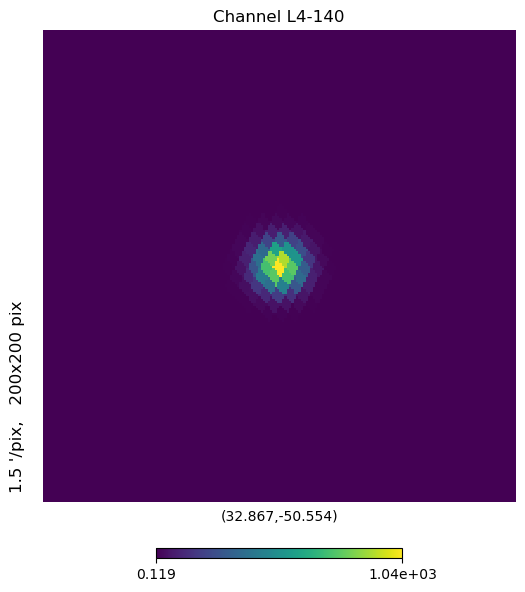

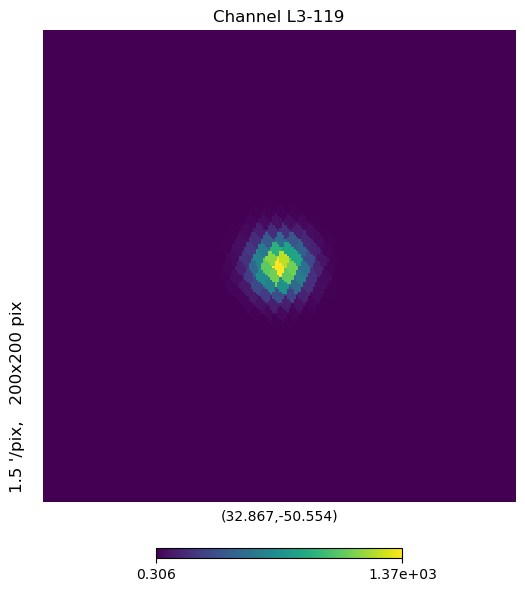

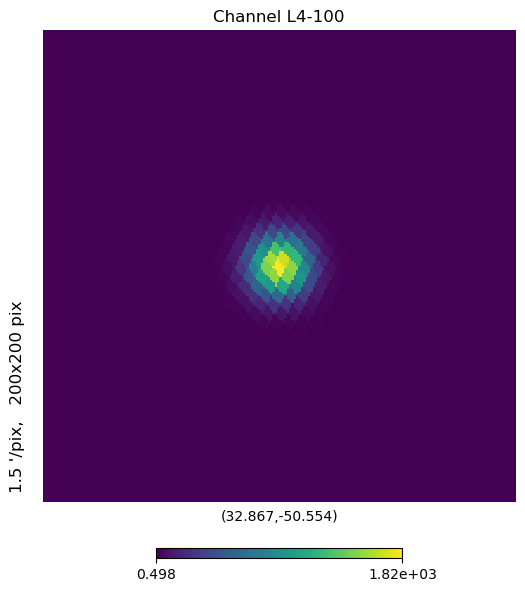

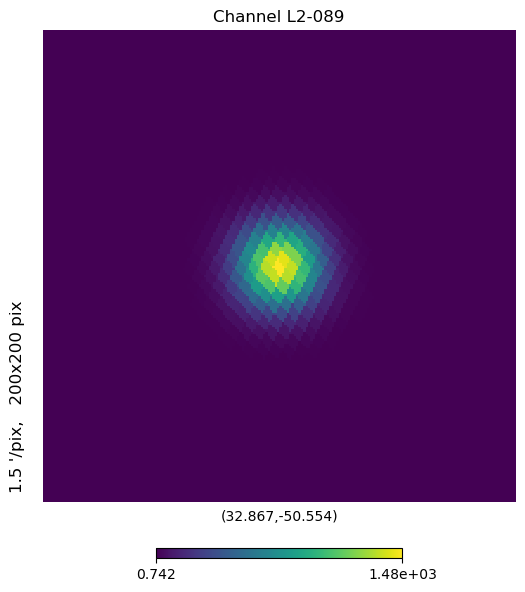

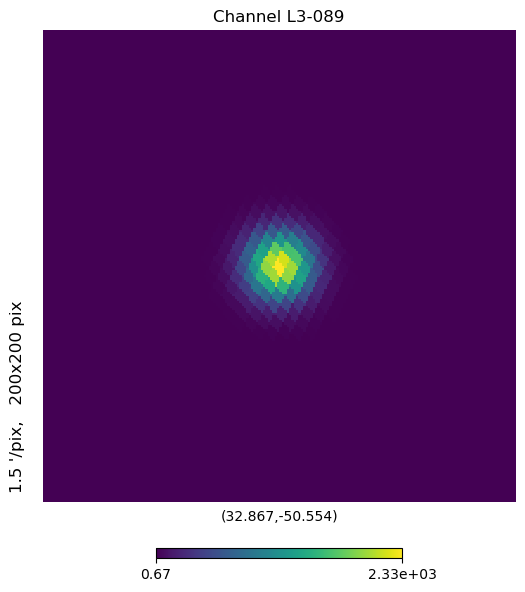

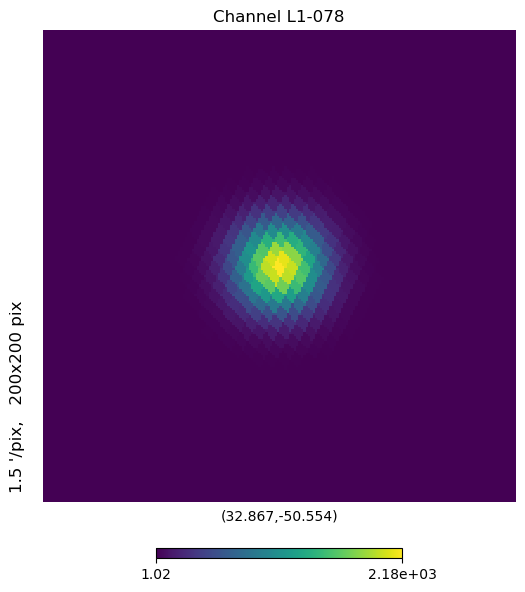

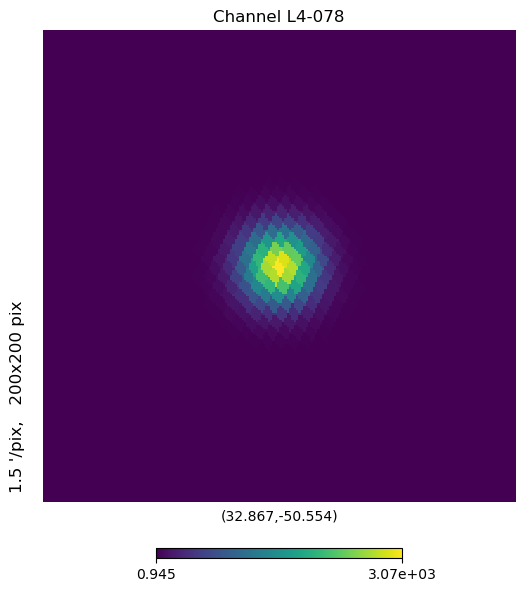

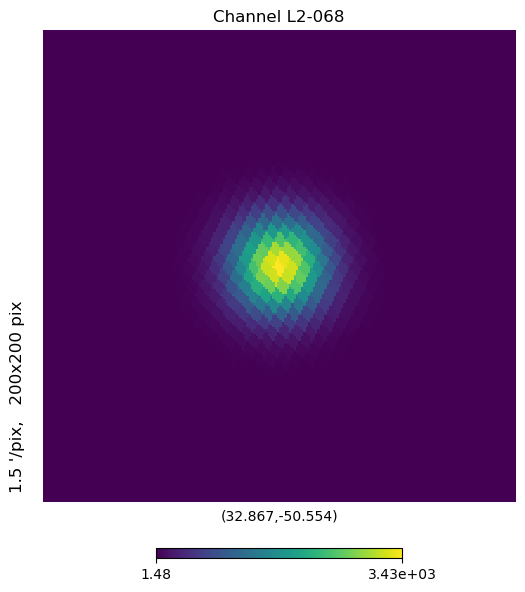

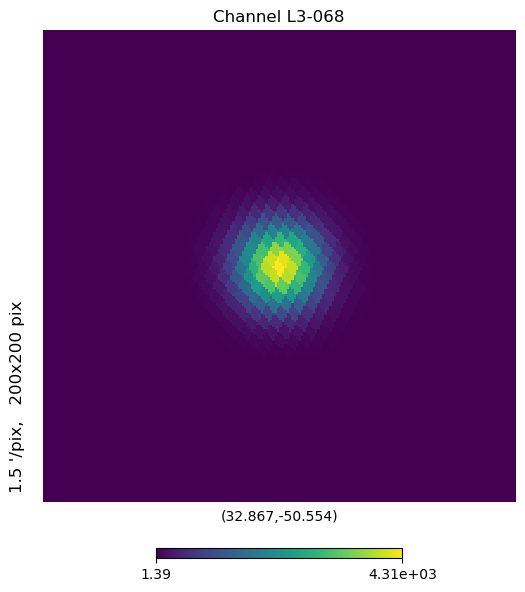

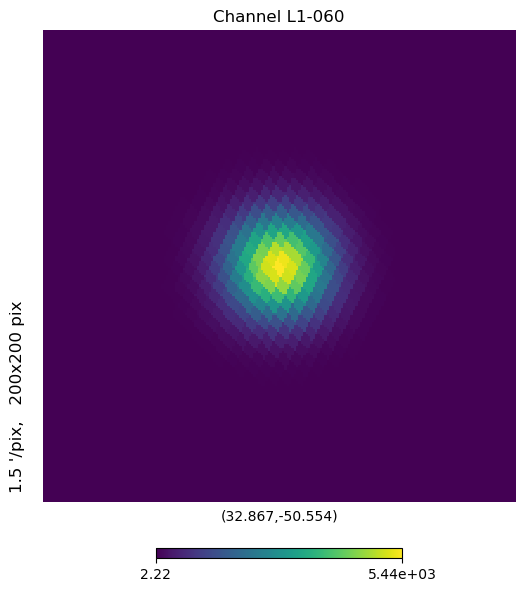

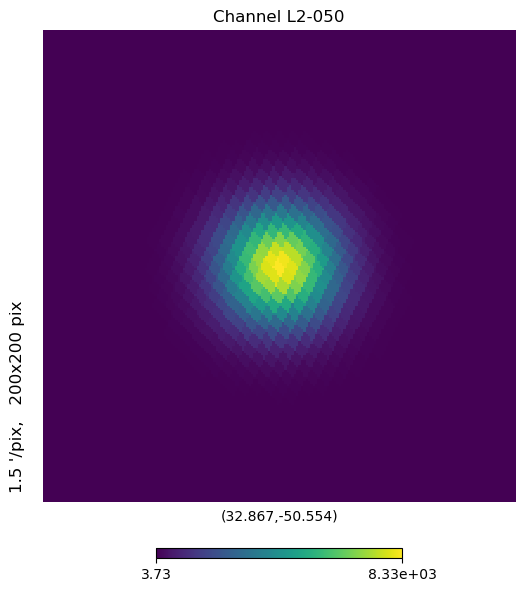

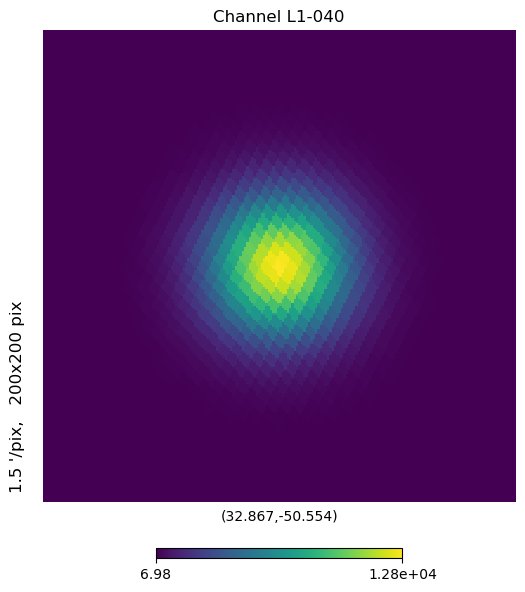

In [13]:
for ch in chs:
    for model in ["radio_rg1"]:
        print(ch, model, end=" - ")
        tag = model
        folder = Path(config["output_folder"].format(tag=tag))
        filename = config["output_filename_template"].format(tag=tag, telescope=ch.telescope, nside=ch.nside, band=ch.band)
        m = hp.read_map(folder / filename) * u.uK_CMB
        nside = hp.npix2nside(len(m))
        vec = hp.ang2vec(clon, clat, lonlat=True)
        disc_ipix = hp.query_disc(nside, vec, ch.beam.to_value(u.radian)*2)
        flux = m[disc_ipix].sum().to(u.Jy/u.sr, equivalencies=u.cmb_equivalencies(ch.center_frequency)) * (hp.nside2pixarea(nside) * u.sr)
        rflux = np.interp(ch.center_frequency.value, np.array(ref_flux.index), ref_flux.values.flatten())*u.Jy
        fractional_error = flux/rflux - 1
        print(f"Flux {flux:.2f} Ref flux {rflux:.2f} Ratio {fractional_error:.2%}")
        assert np.abs(fractional_error) < .3
        hp.gnomview(m, rot=(clon, clat), title=ch)